# Random Forest


In [1]:
# import

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import KFold 


In [2]:
taille_fenetre_to_run = 20
taille_stride_to_run = 5
# 20w_5s déterminer dans search window size 

In [3]:
data = pickle.load(open(f"Data/donnees_{taille_fenetre_to_run}w_{taille_stride_to_run}s.pkl", "rb"))

In [4]:
data.keys()

dict_keys(['X_np_label', 'X_np_binary', 'y_np', 'features_names_label', 'features_names_binary', 'idx_explicabilite', 'X_label_explicabilite', 'X_binary_explicabilite', 'y_explicabilite'])

In [5]:
X_np_label = data["X_np_label"]
y_np = data["y_np"]

In [6]:
X_label_explicabilite = data["X_label_explicabilite"]
y_explicabilite = data["y_explicabilite"]

In [7]:
features_label = data["features_names_label"]

In [8]:
X_np_label.shape

(19010, 152)

In [9]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) 

mse_scores = []
mae_scores = []
mape_scores = []
rmse_scores = []

# déterminer par grid search : 
# {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

rf = RandomForestRegressor(n_estimators=200, 
                           min_samples_split=2, 
                           min_samples_leaf=1, 
                           max_depth=None, 
                           bootstrap=True,
                           random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_np_label)):
    print(f"Running fold {fold+1}/{n_splits}")
    X_train, X_test = X_np_label[train_index], X_np_label[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    rmse_scores.append(rmse)

    # save the model to disk
    filename = f'Models/RandomForest_{taille_fenetre_to_run}_fold_{fold}.sav'
    pickle.dump(rf, open(filename, 'wb'))
    

Running fold 1/5
Running fold 2/5
Running fold 3/5
Running fold 4/5
Running fold 5/5


In [10]:
# 15 min 

In [11]:
print(f"Mean MSE: {np.mean(mse_scores)}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Mean MAPE: {np.mean(mape_scores)}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")

Mean MSE: 0.09505094967631325
Mean MAE: 0.15491823287857118
Mean MAPE: 0.0016792438577561838
Mean RMSE: 0.30705152481328996


In [12]:
print(f'MSE scores: {mse_scores}')
print(f'MAE scores: {mae_scores}')
print(f'MAPE scores: {mape_scores}')
print(f'RMSE scores: {rmse_scores}')

MSE scores: [np.float64(0.0861445777390501), np.float64(0.12650759770432213), np.float64(0.07577228909305105), np.float64(0.08608884352657475), np.float64(0.10074144031856817)]
MAE scores: [np.float64(0.1553254147286415), np.float64(0.15929255096488815), np.float64(0.15014044016561415), np.float64(0.15925454910113407), np.float64(0.15057820943257816)]
MAPE scores: [np.float64(0.0016787887663007298), np.float64(0.001727112631012994), np.float64(0.0016252426070005458), np.float64(0.0017326526248614877), np.float64(0.0016324226596051616)]
RMSE scores: [np.float64(0.2935039654571129), np.float64(0.35567906559751605), np.float64(0.2752676680851768), np.float64(0.2934090038266971), np.float64(0.31739792109994697)]


In [13]:
# get meilleur fold
best_fold = np.argmin(mse_scores)
print(f"Best fold: {best_fold}")

# "Si vous êtes strict sur la validation ou travaillez avec de grandes quantités de données, préférez le meilleur modèle de KFold."

Best fold: 2


In [ ]:
# insert results dans db pickle

results = {
    "mse": mse_scores,
    "mae": mae_scores,
    "mape": mape_scores,
    "rmse": rmse_scores,
    "mean_mse": np.mean(mse_scores),
    "mean_mae": np.mean(mae_scores),
    "mean_mape": np.mean(mape_scores),
    "mean_rmse": np.mean(rmse_scores),
    "best_fold": np.argmin(mse_scores),
}

In [14]:
rf_best = pickle.load(open(f'Models/RandomForest_{taille_fenetre_to_run}_fold_{best_fold}.sav', 'rb'))

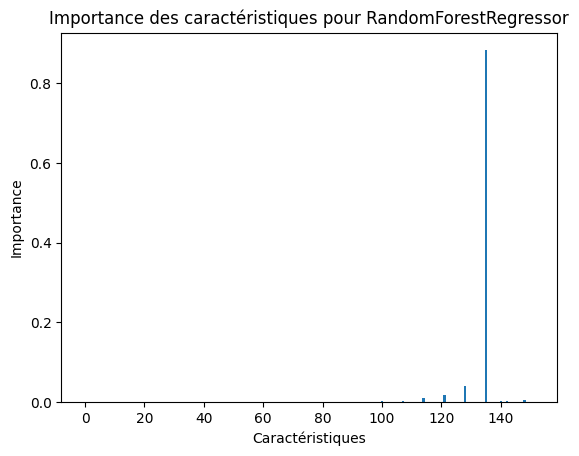

In [15]:
# Récupérer l'importance des caractéristiques
feature_importances = rf_best.feature_importances_

# Afficher l'importance des caractéristiques sous forme de graphique
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques pour RandomForestRegressor')
plt.show()


In [16]:
print(len(features_label))
print(X_np_label.shape)
print(len(feature_importances))
# ok tout semble cohérent 

152
(19010, 152)
152


In [17]:
import shap

# Créer un explainer SHAP pour RandomForest
explainer = shap.TreeExplainer(rf_best)

# # Calculer les valeurs SHAP pour les donnéeschoisies pour l'explicabilité
shap_values = explainer.shap_values(X_label_explicabilite)

# Visualiser les valeurs SHAP pour une prédiction
shap.initjs()  # Pour activer les visualisations interactives


/Users/zoemarquis/Documents/projet_industrie/projet_batteries/mon_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


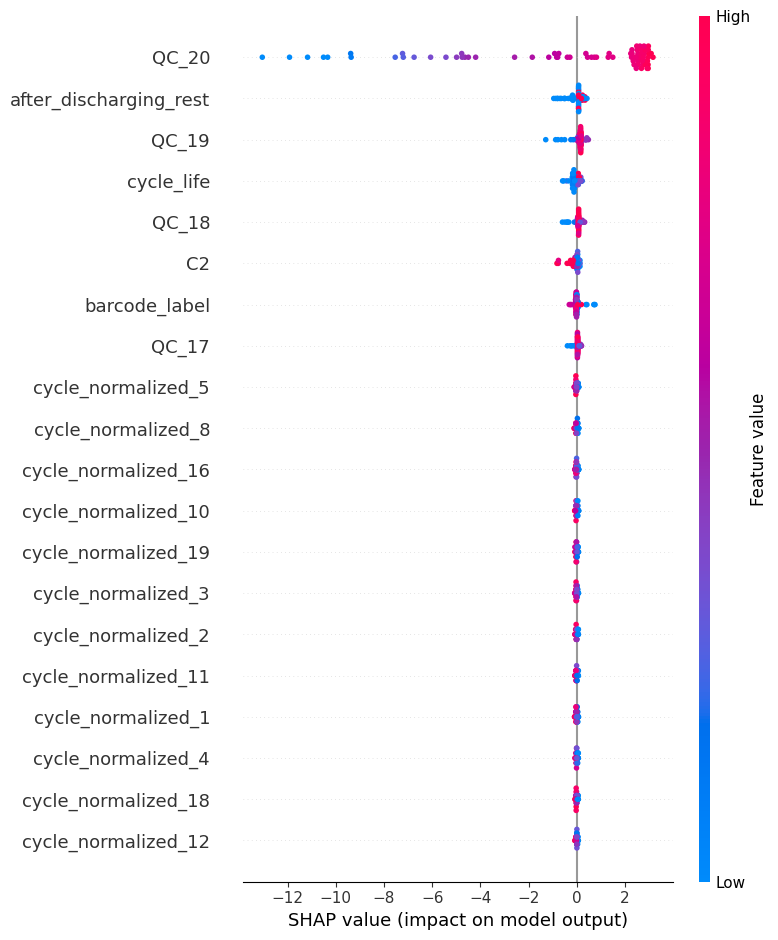

In [18]:
# Visualiser les valeurs SHAP avec un graphique résumé
shap.summary_plot(shap_values, X_label_explicabilite, feature_names=features_label, show=False)

# Sauvegarder la visualisation dans un fichier
plt.savefig(f"Images/shap_RF_{taille_fenetre_to_run}w_{taille_stride_to_run}s.png")
plt.show()

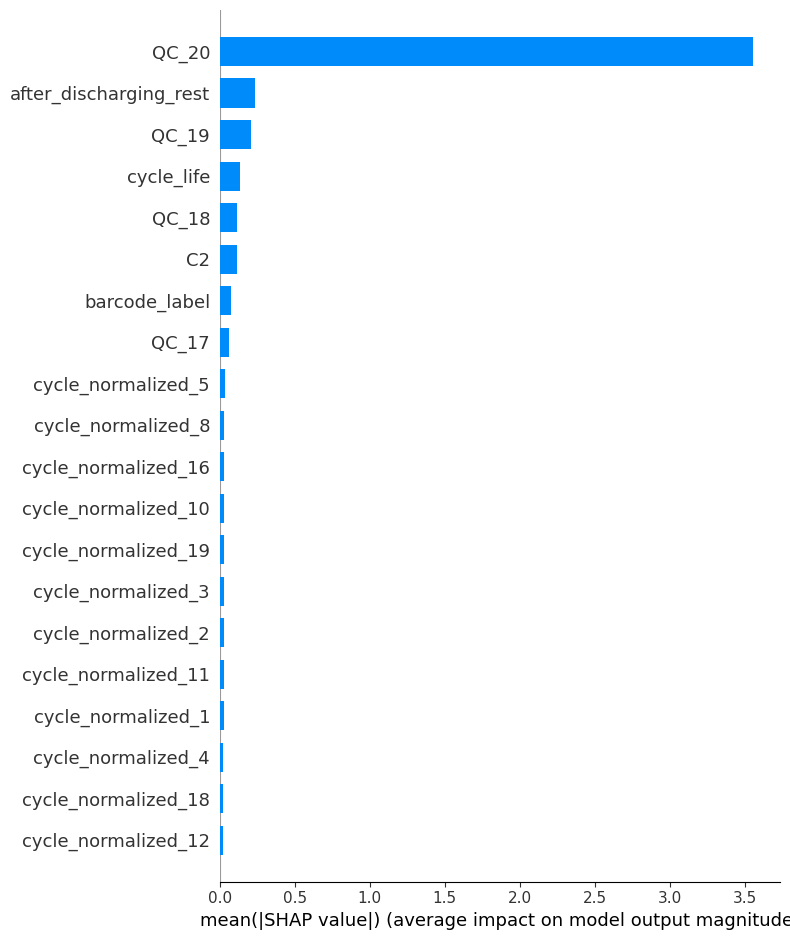

In [19]:
# SHAP Bar Plot
# Une version simplifiée et agrégée du summary plot.
# Montre les caractéristiques les plus importantes globalement.
# Classe les caractéristiques par ordre décroissant d’importance.
shap.summary_plot(shap_values, X_label_explicabilite, feature_names=features_label, plot_type="bar", show=False)

In [20]:
# # indice de la feature
# idx_QC_20 = features_label.index("QC_20")
# print(idx_QC_20)

# idx_after_discharging_rest = features_label.index("after_discharging_rest")
# print(idx_after_discharging_rest)

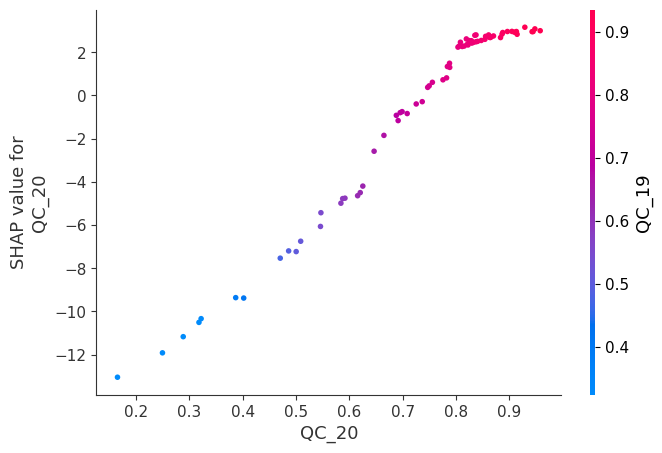

In [21]:
# SHAP Dependence Plot
# Explore la relation entre une caractéristique spécifique et les valeurs SHAP.
# Montre l’effet de la caractéristique sur la prédiction.
# Les points rouges ou bleus représentent les autres caractéristiques corrélées

# shap.dependence_plot("feature_name", shap_values, X_label_explicabilite, feature_names=features_label, show=False)
shap.dependence_plot("QC_20", shap_values, X_label_explicabilite, feature_names=features_label, show=False)

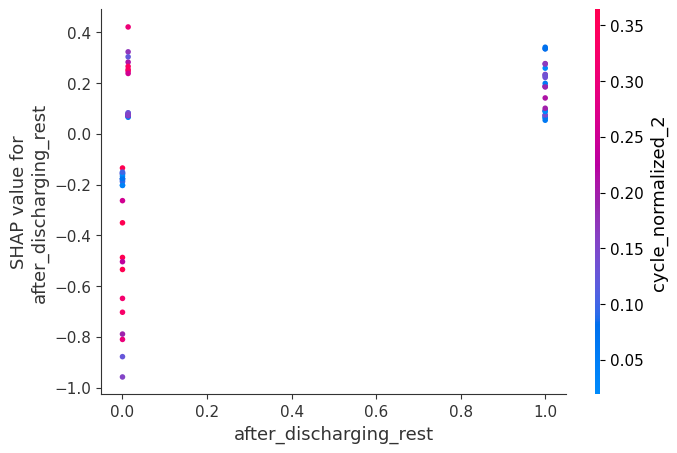

In [22]:
shap.dependence_plot("after_discharging_rest", shap_values, X_label_explicabilite, feature_names=features_label, show=False)

In [23]:
# SHAP Force Plot
# Visualise les contributions individuelles pour chaque prédiction.
# Permet de visualiser comment chaque caractéristique influence une prédiction spécifique.
# Utilise des forces additives (rouge = pousse vers une prédiction plus haute, bleu = pousse vers une prédiction plus basse).

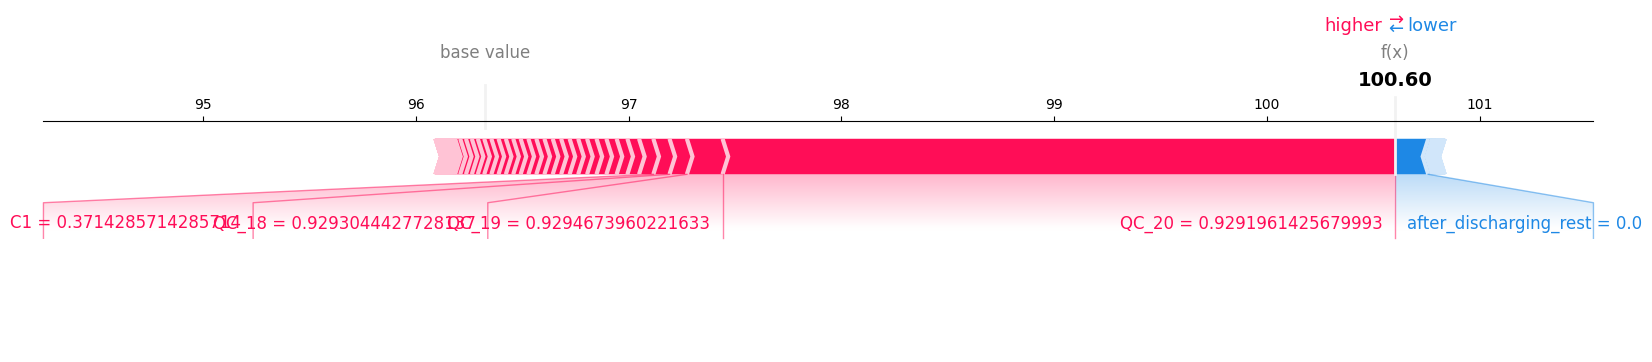

In [24]:
# 0 à 23 : batch 1
shap.force_plot(explainer.expected_value, shap_values[0,:], X_label_explicabilite[0,:], feature_names=features_label, matplotlib=True, show=False)

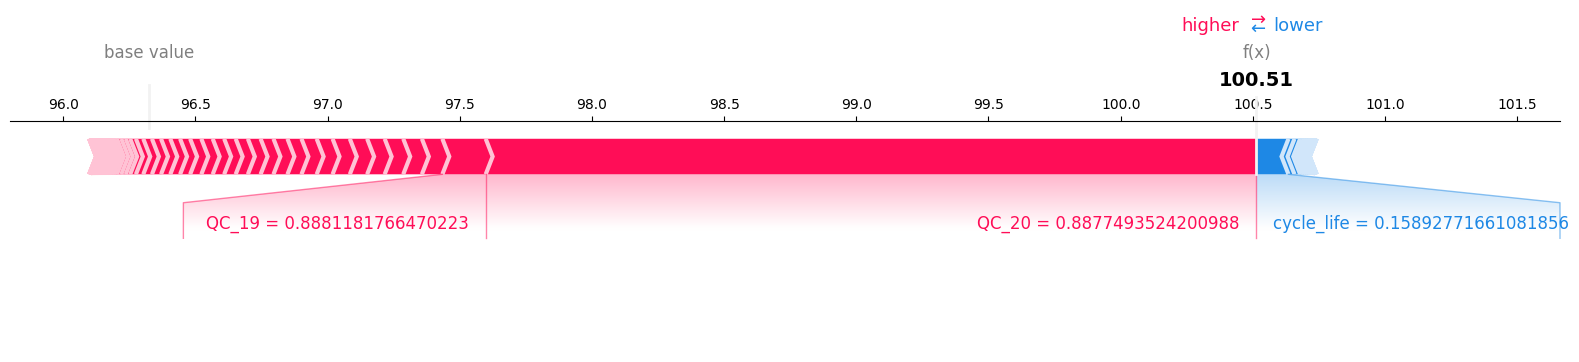

In [25]:
# 24 à 28 : batch 2
shap.force_plot(explainer.expected_value, shap_values[25,:], X_label_explicabilite[25,:], feature_names=features_label, matplotlib=True, show=False)


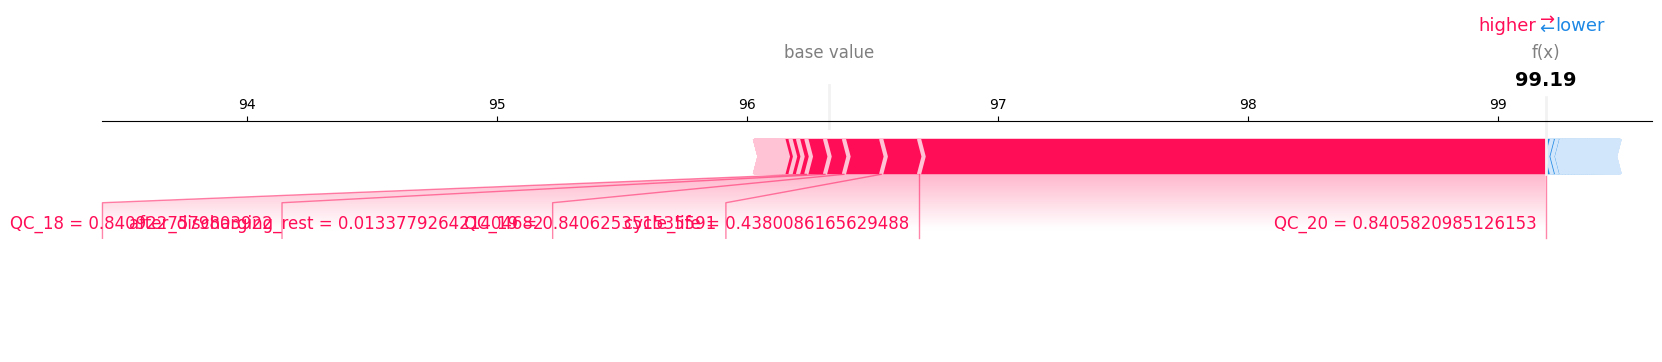

In [26]:
# 49 à 72 : batch 3
shap.force_plot(explainer.expected_value, shap_values[50,:], X_label_explicabilite[50,:], feature_names=features_label, matplotlib=True, show=False)

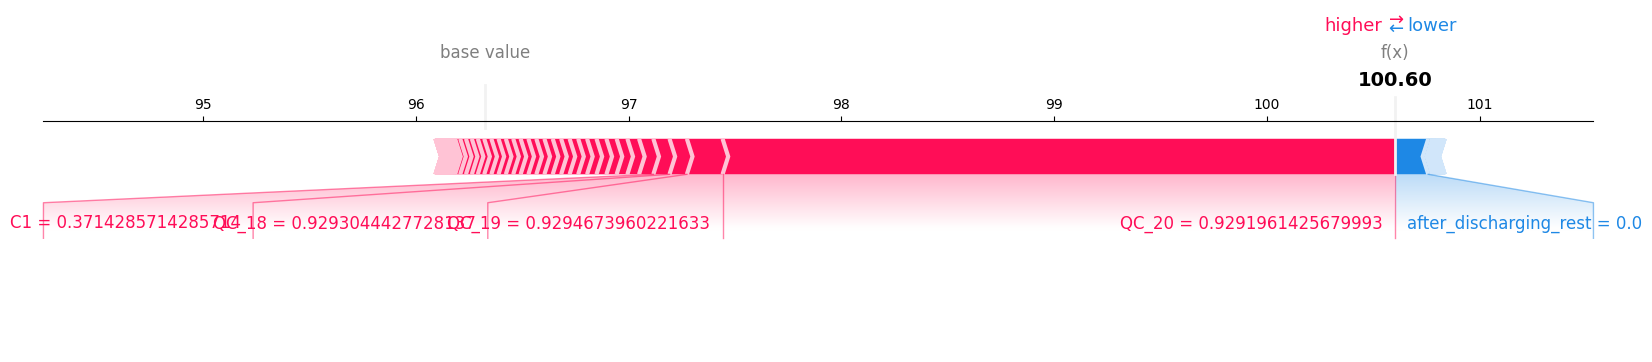

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_label_explicabilite[0,:], feature_names=features_label, matplotlib=True, show=False)

In [28]:
# SHAP Waterfall Plot
# Décompose l'impact des caractéristiques sur une seule prédiction.
# Montre comment la prédiction a été ajustée à partir de la valeur de base (output moyen).
# Utile pour une explication locale.

# TODO
# shap.waterfall_plot(explainer.expected_value, shap_values[0,:], X_label_explicabilite[0,:], feature_names=features_label, show=False)

In [29]:
# batch 1
# TODO : kj'ai pas réussi

In [30]:
# SHAP Decision Plot
# Montre comment les caractéristiques influencent les prédictions à travers toutes les observations.
# Visualise la trajectoire de la prédiction en fonction des caractéristiques.
# Chaque ligne représente une observation.

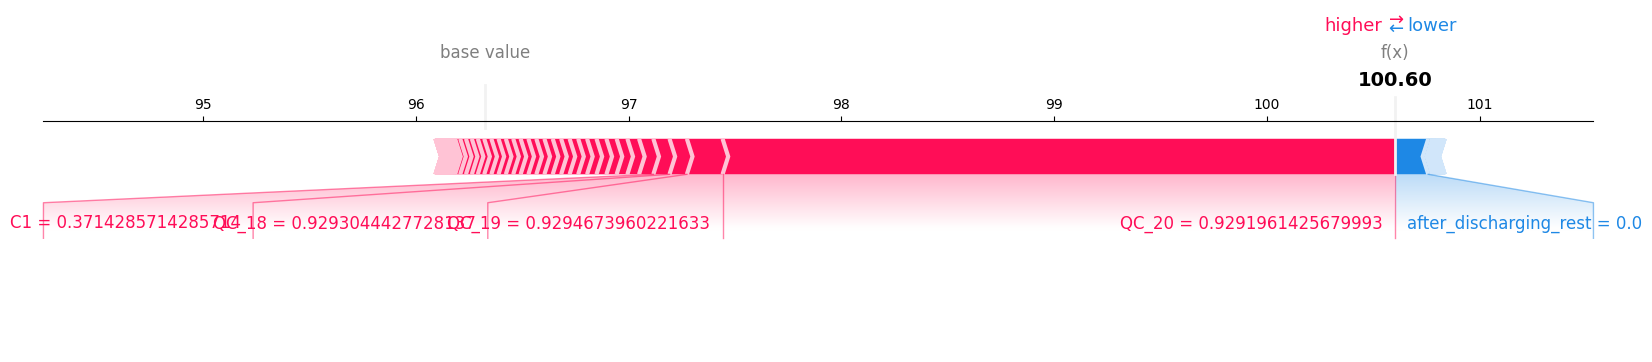

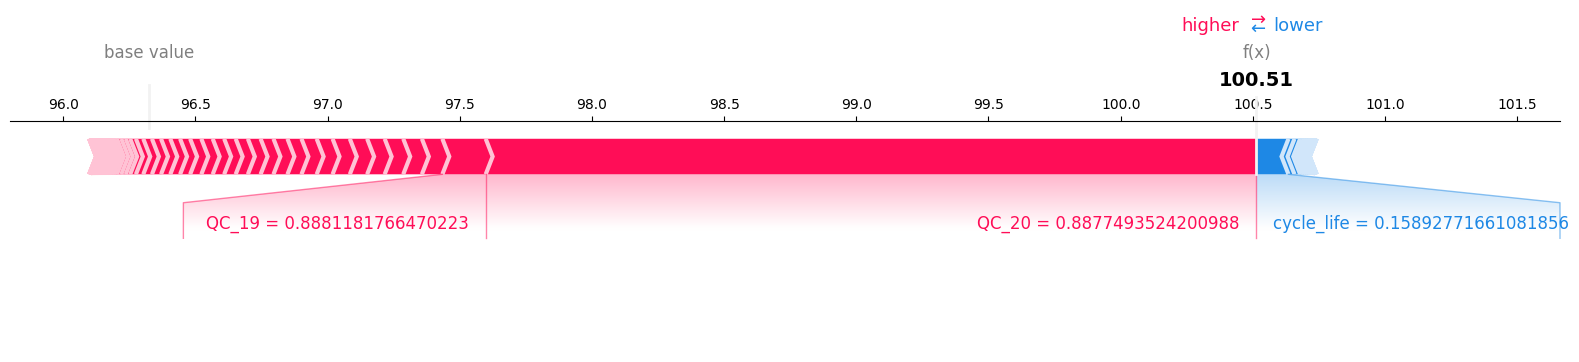

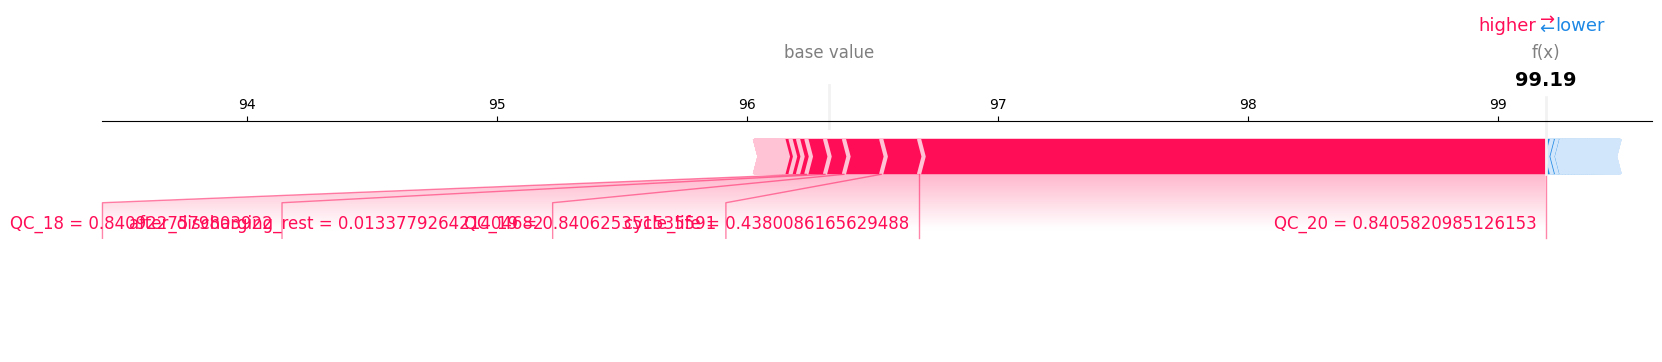

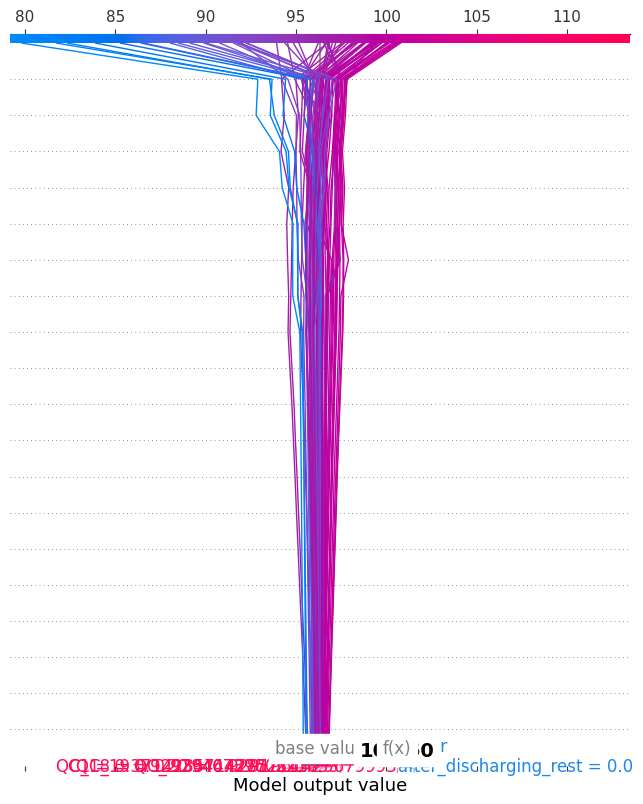

In [31]:
shap.decision_plot(explainer.expected_value, shap_values, X_label_explicabilite, feature_names=features_label, link='identity')

In [32]:
# SHAP Beeswarm Plot
# Une autre version du summary plot, où les caractéristiques importantes sont sur l’axe vertical.
# Chaque point représente une observation et sa valeur SHAP.
# Classe les caractéristiques par importance globale.

# TODO
# shap.summary_plot(shap_values, X_label_explicabilite, feature_names=features_label, plot_type="beeswarm", show=False)
# plot_type="dot"

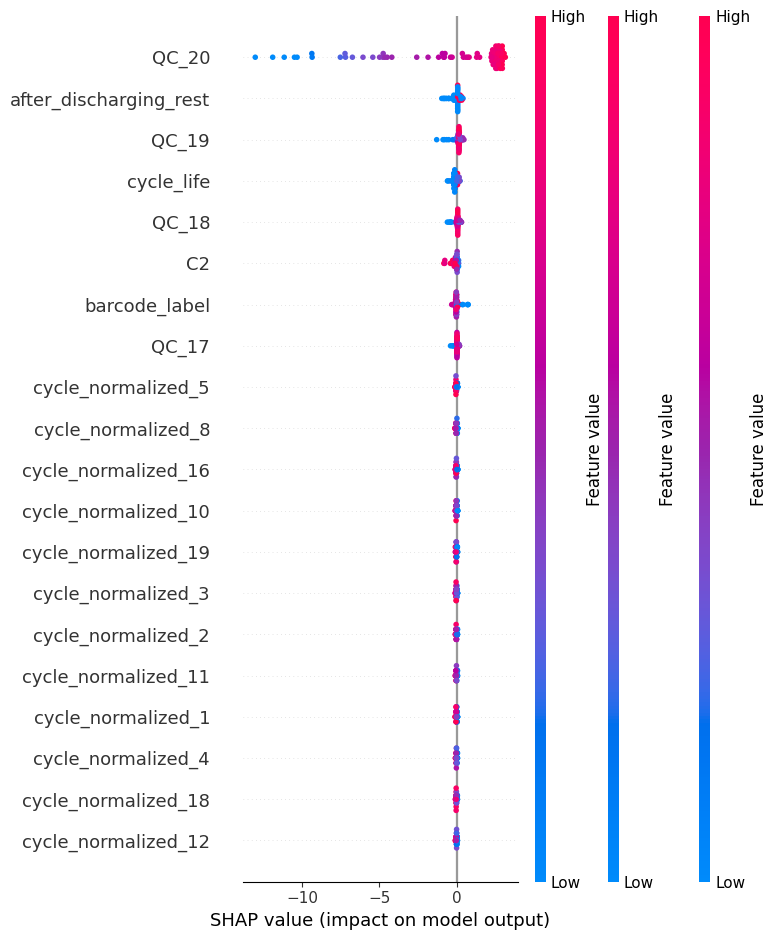

In [37]:
shap.summary_plot(shap_values, X_label_explicabilite, feature_names=features_label, plot_type="beeswarm")

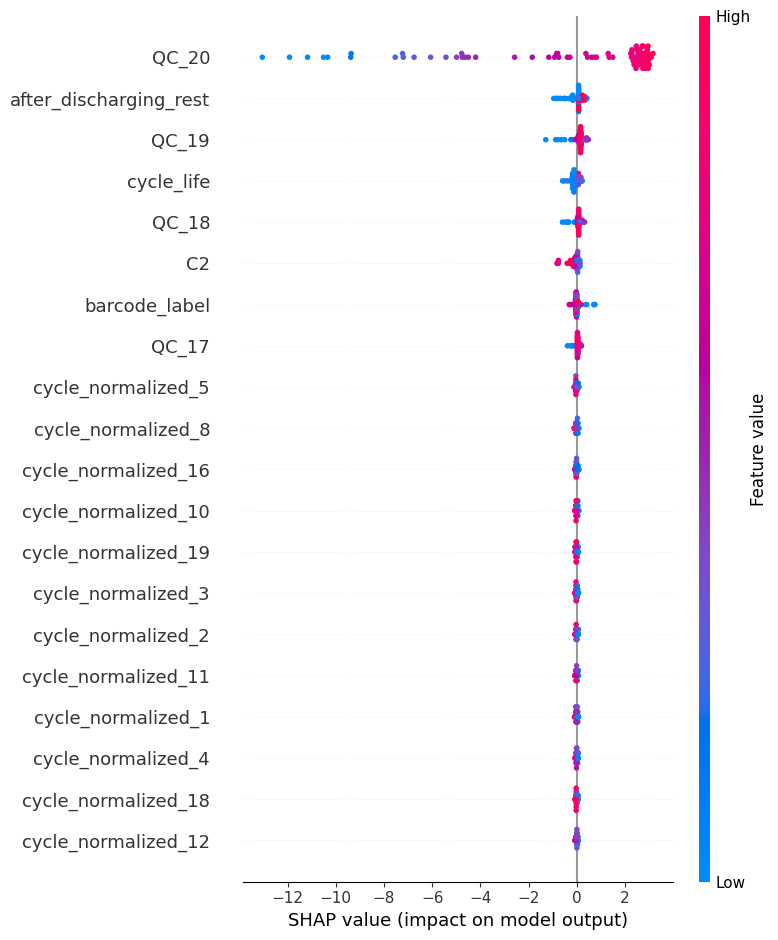

In [38]:
shap.summary_plot(shap_values, X_label_explicabilite, feature_names=features_label, plot_type="dot")

In [ ]:
# SHAP Interaction Values Plot
# Montre les interactions entre les caractéristiques.
# Analyse les interactions entre les paires de caractéristiques.
# Nécessite que l'explainer calcule les valeurs d'interaction SHAP.
# # TODO 
# c'est méga lon je me demande si on laisse pas tomber ce plot là 
shap_interaction_values = explainer.shap_interaction_values(X_label_explicabilite)
shap.summary_plot(shap_interaction_values, X_label_explicabilite, feature_names=features_label)